Source: https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274/code 


# Libraries and Global Parameters 

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte
from skimage.transform import resize
#import skimage
#import glob
import random
from random import randint #, shuffle
from skimage.morphology import label


from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy

model_checkpoint_file='meshnet_v4.h5'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

Using TensorFlow backend.


# Preparing the Data

In [2]:
## Import Training Data Images 
train_dirs = os.listdir(train_root)
train_filenames=[os.path.join(train_root,file_id) + "/images/"+file_id+".png" for file_id in train_dirs]
# Convert to B&W inline
#train_images=[cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2GRAY) for imagefile in train_filenames]
train_images=[imread(imagefile,as_grey=True) for imagefile in train_filenames]

# Use this instead if you want color images
#train_images=[imread(imagefile) for imagefile in train_filenames]


In [6]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]

#def collapse_masks(mask_list):
#    for i, mask_file in enumerate(mask_list):
#        print(i)
#        print(mask_file)
        
#testing = [collapse_masks(mask_files) for mask_files in train_mask_files]

# Divide output of each mask by 255 to make a 1/0 binary mask
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]


# Computer Vision Technique

In [4]:
def comp_viz_mask(img):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
   # img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc # convert to 1/0

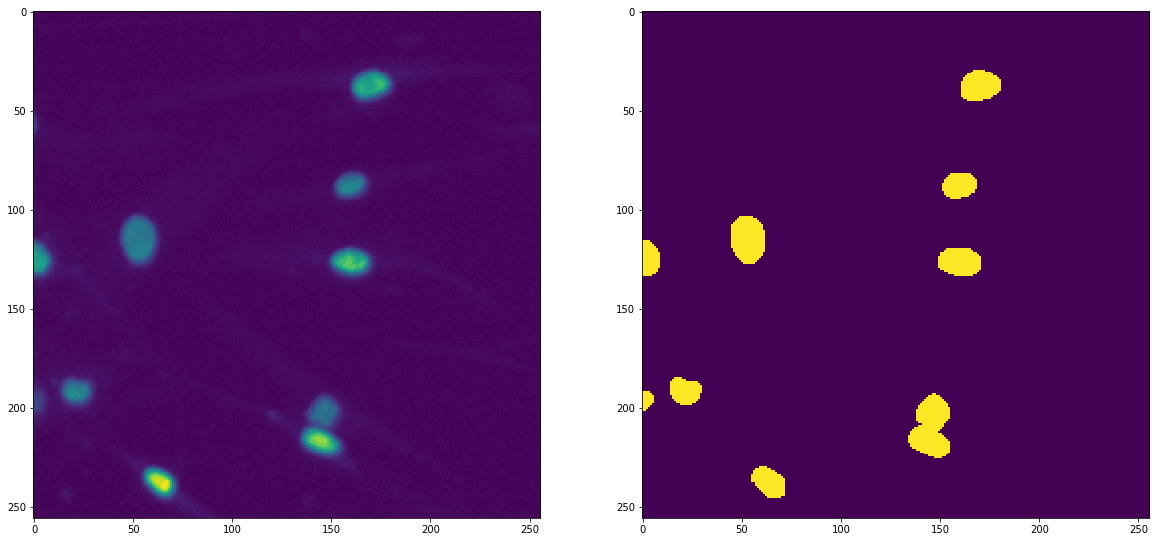

In [19]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num):
    #print('Image #: ' + str(image_num) + '. Image Sizes: ' + str(image_ds[image_num].shape) + ' ' + str(mask_ds[image_num].shape))
    fig = plt.figure(figsize=(20,10))

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1))
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i])
    
#plot_side_by_side(train_images,train_mask_images,38)
# Plot a few random images 
#plot_check(train_images,train_masks,rand_imgs=3)
plot_check([train_images,train_masks],rand_imgs=1)
#plot_check(train_images,cv2_masks,rand_imgs=3)

#plot_check(train_images,train_mask_images,img_nums=[309])



In [20]:
# Resize everything
# Also do dtype conversions

# Scaling
resized_train_images = [ img_as_ubyte(resize(image,(img_width,img_height))) for image in train_images] 

resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
#resized_train_cv2_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_cv2_masks] 

#Croping

#crop_size=64

#resized_train_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
#   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_images] 

#resized_train_mask_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
#   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_mask_images] 


In [9]:
# check max pixel values
print(resized_train_images[309].max())
print(resized_train_images[16].max())

87
170


In [10]:
# Reshape model inputs
train_X = np.reshape(np.array(resized_train_images),(len(resized_train_images),img_height,img_width,1))

# Stack cv2 masks on top of images as a channel
#train_X = np.reshape(np.stack((np.array(resized_train_images),np.array(resized_train_cv2_masks)),axis=3), \
#                     (len(resized_train_images),img_height,img_width,2))
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,1))

# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time
print(train_X.shape)
print(train_Y.shape)
print(train_X.nbytes)
print(train_Y.nbytes)

(670, 128, 128, 1)
(670, 128, 128, 1)
10977280
10977280


In [ ]:
# Check datatypes
print(train_Y.dtype)
print(train_X.dtype)

#train_X[0]

# Now Let's Build the Model

In [21]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=20, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.1):
#    for i in range(n_block):
    x = Conv2D(filters, filter_size, padding='same', activation='relu', dilation_rate = dil_rate) (x)
    x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,1),
        loss=binary_crossentropy,
        n_class=1
):
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs)
    net_body = create_block(net_body)
    net_body = create_block(net_body)
    net_body = create_block(net_body,dil_rate=2)
    net_body = create_block(net_body,dil_rate=4)
    net_body = create_block(net_body,dil_rate=8)
    net_body = create_block(net_body)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)
    
    #classify = Activation(activation='sigmoid') (net_body)
    #classify = Dense(1,activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(0.001), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

In [22]:
my_model = get_net()

In [23]:
print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 20)      200       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 20)      80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 20)      3620      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 20)      80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 20)      0         
__________

In [25]:
# Fit model

earlystopper = EarlyStopping(patience=12, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=20, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
600/603 [============================>.] - ETA: 1s - loss: 0.6407 - bce_dice_loss: 1.3271 - dice_coef: 0.4302 
Epoch 00001: val_loss improved from inf to 0.34051, saving model to meshnet_v4.h5
603/603 [==============================] - 285s 473ms/step - loss: 0.6410 - bce_dice_loss: 1.3284 - dice_coef: 0.4292 - val_loss: 0.3405 - val_bce_dice_loss: 0.8827 - val_dice_coef: 0.7231
Epoch 2/100
600/603 [============================>.] - ETA: 1s - loss: 0.4324 - bce_dice_loss: 1.0022 - dice_coef: 0.6824
Epoch 00002: val_loss improved from 0.34051 to 0.33867, saving model to meshnet_v4.h5
603/603 [==============================] - 268s 445ms/step - loss: 0.4324 - bce_dice_loss: 1.0017 - dice_coef: 0.6823 - val_loss: 0.3387 - val_bce_dice_loss: 0.8394 - val_dice_coef: 0.6980
Epoch 3/100
600/603 [============================>.] - ETA: 1s - loss: 0.3327 - bce_dice_loss: 0.8331 - dice_coef: 0.7458 
Epoch 00003: val_loss did not improve
603

Epoch 23/100
600/603 [============================>.] - ETA: 1s - loss: 0.0998 - bce_dice_loss: 0.3016 - dice_coef: 0.8625
Epoch 00023: val_loss did not improve
603/603 [==============================] - 265s 439ms/step - loss: 0.1005 - bce_dice_loss: 0.3024 - dice_coef: 0.8622 - val_loss: 0.0863 - val_bce_dice_loss: 0.2682 - val_dice_coef: 0.8628
Epoch 24/100
600/603 [============================>.] - ETA: 1s - loss: 0.0980 - bce_dice_loss: 0.2983 - dice_coef: 0.8654
Epoch 00024: val_loss improved from 0.08053 to 0.07981, saving model to meshnet_v4.h5
603/603 [==============================] - 264s 438ms/step - loss: 0.0980 - bce_dice_loss: 0.2984 - dice_coef: 0.8655 - val_loss: 0.0798 - val_bce_dice_loss: 0.2460 - val_dice_coef: 0.8779
Epoch 25/100
600/603 [============================>.] - ETA: 1s - loss: 0.0968 - bce_dice_loss: 0.2894 - dice_coef: 0.8688
Epoch 00025: val_loss improved from 0.07981 to 0.07505, saving model to meshnet_v4.h5
603/603 [==============================] - 

600/603 [============================>.] - ETA: 1s - loss: 0.0875 - bce_dice_loss: 0.2681 - dice_coef: 0.8795
Epoch 00045: val_loss did not improve
603/603 [==============================] - 264s 437ms/step - loss: 0.0874 - bce_dice_loss: 0.2678 - dice_coef: 0.8797 - val_loss: 0.0739 - val_bce_dice_loss: 0.2359 - val_dice_coef: 0.8829
Epoch 46/100
600/603 [============================>.] - ETA: 1s - loss: 0.0887 - bce_dice_loss: 0.2718 - dice_coef: 0.8772
Epoch 00046: val_loss did not improve

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
603/603 [==============================] - 266s 441ms/step - loss: 0.0890 - bce_dice_loss: 0.2721 - dice_coef: 0.8769 - val_loss: 0.0739 - val_bce_dice_loss: 0.2359 - val_dice_coef: 0.8828
Epoch 47/100
600/603 [============================>.] - ETA: 1s - loss: 0.0886 - bce_dice_loss: 0.2732 - dice_coef: 0.8760
Epoch 00047: val_loss did not improve
603/603 [==============================] - 263s 436ms/step - loss: 0.0

KeyboardInterrupt: 

In [16]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ img_as_ubyte(resize(image,(img_width,img_height))) for image in images] 
    Array = np.reshape(np.array(resized_images),(len(resized_images),img_height,img_width,1))
    return Array, resized_images, images, filenames, dirs


    

test_dirs = os.listdir(test_root)
test_filenames=[os.path.join(test_root,file_id) + "/images/"+file_id+".png" for file_id in test_dirs]
test_images=[imread(imagefile,as_grey=True) for imagefile in test_filenames]
resized_test_images = [ img_as_ubyte(resize(image,(img_width,img_height))) for image in test_images] 
test_X = np.reshape(np.array(resized_test_images),(len(resized_test_images),img_height,img_width,1))

final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


65/65 [==============================] - 21s 324ms/step


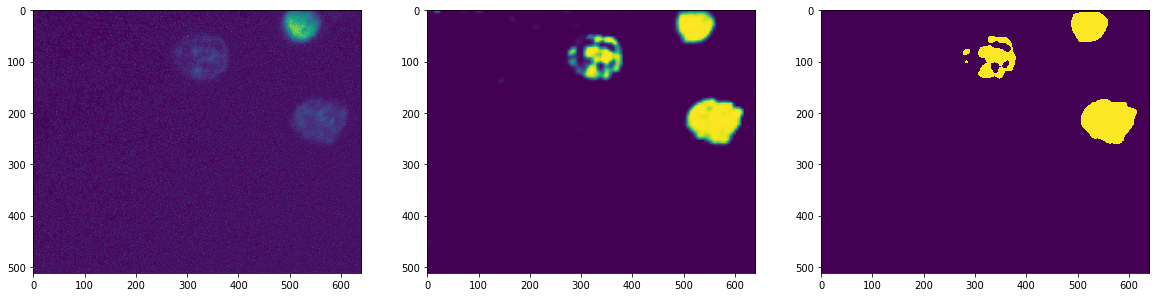

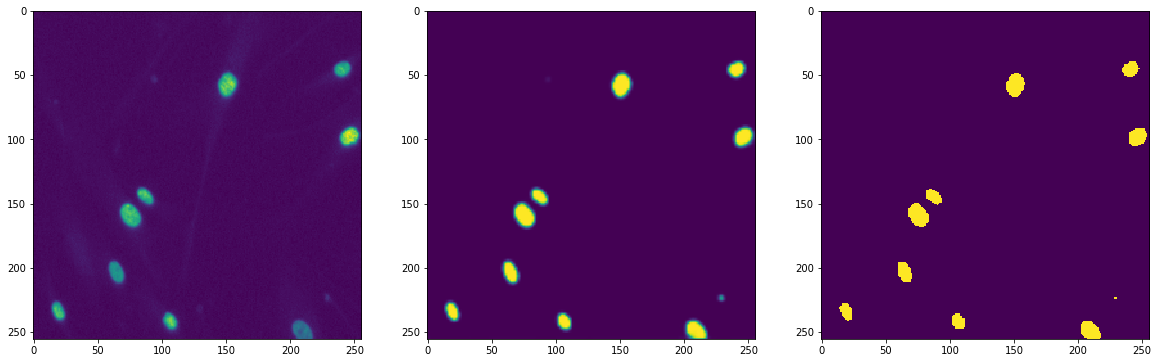

In [53]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [17]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [21]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,'meshnetv4_mesh_pred.csv')

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data